In [106]:
# 說明：設置環境、import 套件
import pandas as pd
import numpy as np
import pprint 
import matplotlib.pyplot as plt
from matplotlib import pylab
%pylab inline
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (20, 8)

Populating the interactive namespace from numpy and matplotlib


In [107]:
import matplotlib.font_manager as fm 
myfont = fm.FontProperties( fname="/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc")   

In [108]:
# Global variables
CostRate = 3 # 一度電多少錢（估算，實際還要再確認）

### 原始資料說明 - 1
- 區間：去年 09/01 - 11/10，七一天
    - 這份資料區間以方便分析為主，所以 71 天只是 1.0 版本，之後會擴張到整學期
- 間隔：一小時一筆
- 地點：所有的學生宿舍，以下我是針對十二舍做
- 一個地點的筆數：每棟大樓共 71(day) * 24(hr) = 1704 筆
- 總筆數 = 1704 * 17 = 28968 筆

In [109]:
df = pd.read_csv('data/data0226_0901_1110_hr_dorm.csv') # 讀檔案
df.columns # 有哪些欄位

Index(['DateTime', 'Area', 'Building', 'Loop', 'Type', 'Usage'], dtype='object')

### 原始資料說明 - 2
- index: ['﻿時  間', '區 域', '館 舍 別', '迴 路 別', '用電別', '用電量(單位:度)']

### 人工資料前處理：改變欄位名稱
#### 改變的原因
- 原始的資料有空白在字串裡，會造成一些麻煩
- 英文的名稱，可以在Pandas寫Code時較為方便(才能用 df.Usage的指令)

#### 改了什麼
- 我用Number(Excel)的尋找取代功能，把資料轉成英文，以下括弧表示原始資料的命名
    - 區域：southArea(南區), northArea(北區)
    - 迴 路 別: mainLoop（主迴路）, familyMart（1F便利超商）, club（社團）, socialHall（閱覽交誼廳）, studentHall（學生交誼廳）, streetLight(環校路燈),
    - 館舍： dorm_13（學生十三舍）,(7,8,9,10,11,12 以此類推), dorm_graduate_2（研二）, dorm_87（學生七舍＿八舍）, dorm_13_graduate_1(11與研一), dorm_chu（竹軒）
    - 用電別：rent（外租）, dorm（宿舍）, admin(行政)

Adrain建議: 這部分應該透過 Pandas 寫好，才可以省下每筆資料要手動處理的時間

---
# 以下開始，正式透過 Pandas 來處理 / 分析資料

### 新增欄位：由DateTime的資訊，新增日期、時間、Weekday、Week
- def generate_date_time_columns(df)
    - 放進一個含有 DateTime 欄位的 df, 並寫且回傳新增 Date, Time, Weekday, Week的欄位
- Date, Time: 為了之後更方便用日期、時間去存取，分群比較。
- Weekday: 為了去了解週一到週日的用電變化
- Weekday: 為了後續容易掌握每週變化

In [110]:
def generate_date_time_columns(df):
    if('DateTime' in df.columns):
            df['Date'] = df.DateTime.str[:10]
            df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
            df['Weekday'] = df['Date'].dt.dayofweek + 1
            df['Time'] = df.DateTime.str[11:]
            df['Week'] = df['Date'].dt.week
            print('Columns #Date, #Time, #Weekday, #Week has been generated from DateTime and added to DataFrame')
    else:
        print('DataTime not in column. Please rename columns name.')
    return df

In [111]:
df = generate_date_time_columns(df)

Columns #Date, #Time, #Weekday, #Week has been generated from DateTime and added to DataFrame


In [112]:
# cost_rate：一度電大概多少錢
def generate_cost_columns(df, cost_rate):
    df['Cost'] = df.Usage * cost_rate
    print('Column "Cost" had been generated!')
    return df

In [113]:
df = generate_cost_columns(df, CostRate)

Column "Cost" had been generated!


### 將資料切成三份
原本的資料集包含不同種類（宿舍、外租、行政）的欄位，而因為我們要專注分析宿舍用電，所以將資料切成三份

In [114]:
df_dorm = df[df.Type == 'dorm'] #以下專注在 df_dorm的分析
df_rent = df[df.Type == 'rent']
df_admin = df[df.Type == 'admin']

### 處理 df_dorm 的離群值

In [115]:
# 找離群值：找出最大的五個值，用肉眼可以看出離群值
df_dorm.sort_values('Usage')[-5:]

DateTime       Area Building         Loop  Type     Usage  \
19247  2017/09/21 23:00  southArea  dorm_87     mainLoop  dorm    346.00   
19367  2017/09/26 23:00  southArea  dorm_87     mainLoop  dorm    348.00   
19343  2017/09/25 23:00  southArea  dorm_87     mainLoop  dorm    350.00   
1955   2017/09/11 11:00  southArea  dorm_13         club  dorm   1039.70   
6277   2017/10/19 13:00  northArea  dorm_10  studentHall  dorm  55471.62   

            Date  Weekday   Time  Week       Cost  
19247 2017-09-21        4  23:00    38    1038.00  
19367 2017-09-26        2  23:00    39    1044.00  
19343 2017-09-25        1  23:00    39    1050.00  
1955  2017-09-11        1  11:00    37    3119.10  
6277  2017-10-19        4  13:00    42  166414.86

In [116]:
# 手動改離群值，如果離群值太多得用更完整的方式
df.loc[6277,'Usage']  = 0.87 #  0.87 約是前後的值得大小
df.loc[6277,'Cost']  = df.loc[6277,'Usage'] * CostRate # 記得連Cost 一起改過來
df.iloc[6277]

DateTime       2017/10/19 13:00
Area                  northArea
Building                dorm_10
Loop                studentHall
Type                       dorm
Usage                      0.87
Date        2017-10-19 00:00:00
Weekday                       4
Time                      13:00
Week                         42
Cost                       2.61
Name: 6277, dtype: object

In [117]:
# 這天的離群值，猜測來自之前欄位的位移
# 驗證：看之前欄位的值，有2145筆是零
print(df.iloc[4207:6277].Usage.value_counts())

0.00    2045
0.25       6
0.26       4
0.24       3
0.19       3
0.20       2
0.21       2
0.22       2
3.24       1
5.41       1
0.01       1
Name: Usage, dtype: int64


### 了解每個欄位有多少種不同的值
因為Pandas似乎只有內建針對特定欄位的 unique ，而沒有把所有欄位的Unique 一次列出來的功能，
就自己寫一個

In [118]:
# 用自訂函式去理解DF中每個欄位有哪幾種類別的值
def understand(df):
    for col_name in df.columns:
        print ('>>> "{}" has {} unique values:'.format(col_name, len(df[col_name].unique())))
        if(len(df[col_name].unique())<50):
            pprint.pprint(df[col_name].unique())
        else:
            pprint.pprint('The value is more than 50 so wont be list here :P')
        print('\n')
understand(df_dorm)

>>> "DateTime" has 1704 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Area" has 2 unique values:
array(['southArea', 'northArea'], dtype=object)


>>> "Building" has 12 unique values:
array(['dorm_13', 'dorm_10', 'dorm_chu', 'dorm_9', 'dorm_11_graduate_1',
       'dorm_11', 'dorm_graduate_1', 'dorm_87', 'dorm_7', 'dorm_8',
       'dorm_12', 'dorm_graduate_2'], dtype=object)


>>> "Loop" has 4 unique values:
array(['club', 'socialHall', 'studentHall', 'mainLoop'], dtype=object)


>>> "Type" has 1 unique values:
array(['dorm'], dtype=object)


>>> "Usage" has 2623 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Date" has 71 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Weekday" has 7 unique values:
array([5, 6, 7, 1, 2, 3, 4])


>>> "Time" has 24 unique values:
array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '

# Part 2 Dorm 12 分析
我們先嘗試建立一個對於交大十二舍(Dorm 12)的分析，接著把這樣的分析方式寫成 general function()，套用到其他宿舍上

In [119]:
df_dorm_12 = df[df.Building == 'dorm_12']

### 基本資訊

In [120]:
df_dorm_12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1704 entries, 23856 to 25559
Data columns (total 11 columns):
DateTime    1704 non-null object
Area        1704 non-null object
Building    1704 non-null object
Loop        1704 non-null object
Type        1704 non-null object
Usage       1704 non-null float64
Date        1704 non-null datetime64[ns]
Weekday     1704 non-null int64
Time        1704 non-null object
Week        1704 non-null int64
Cost        1704 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 159.8+ KB


In [121]:
understand(df_dorm_12)

>>> "DateTime" has 1704 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Area" has 1 unique values:
array(['southArea'], dtype=object)


>>> "Building" has 1 unique values:
array(['dorm_12'], dtype=object)


>>> "Loop" has 1 unique values:
array(['mainLoop'], dtype=object)


>>> "Type" has 1 unique values:
array(['dorm'], dtype=object)


>>> "Usage" has 336 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Date" has 71 unique values:
'The value is more than 50 so wont be list here :P'


>>> "Weekday" has 7 unique values:
array([5, 6, 7, 1, 2, 3, 4])


>>> "Time" has 24 unique values:
array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)


>>> "Week" has 11 unique values:
array([35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])


>>> "Cost" h

In [122]:
df_dorm_12.Usage.describe() #統計上了解用電狀況

count    1704.000000
mean       96.243545
std        38.961526
min        19.000000
25%        69.000000
50%        90.000000
75%       120.500000
max       238.500000
Name: Usage, dtype: float64

### 圖一：Box plot

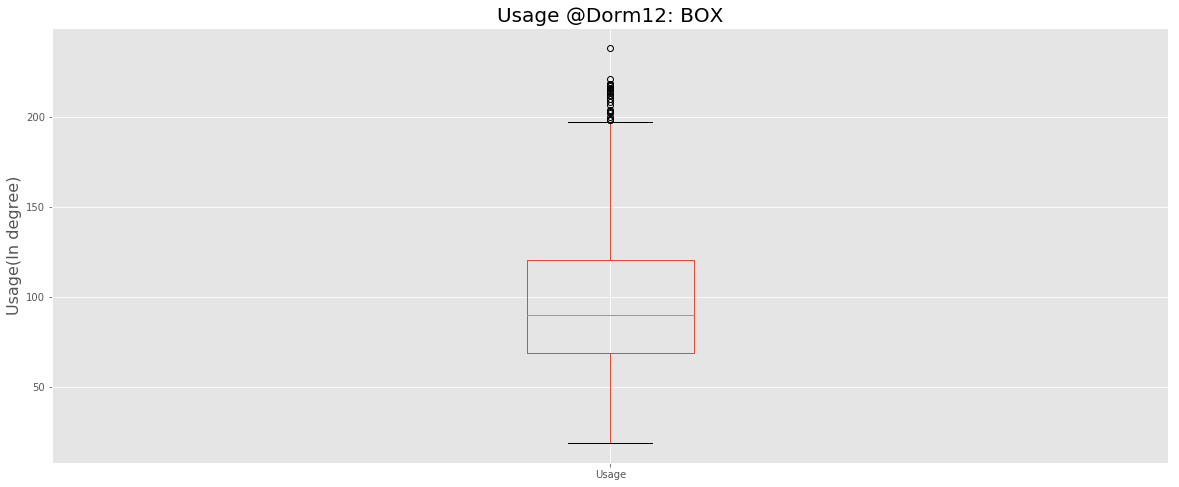

In [123]:
df_dorm_12.Usage.plot.box()
plt.title('Usage @Dorm12: BOX', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
# pylab.xlabel('Time',fontsize = 16)

### 圖二：時間區間內的用電資料（Line Plot）
#### 觀察
- 週末的時候（藍線最高點），通常用電比較低
- 圖片中間有個低潮，猜測是國慶連假

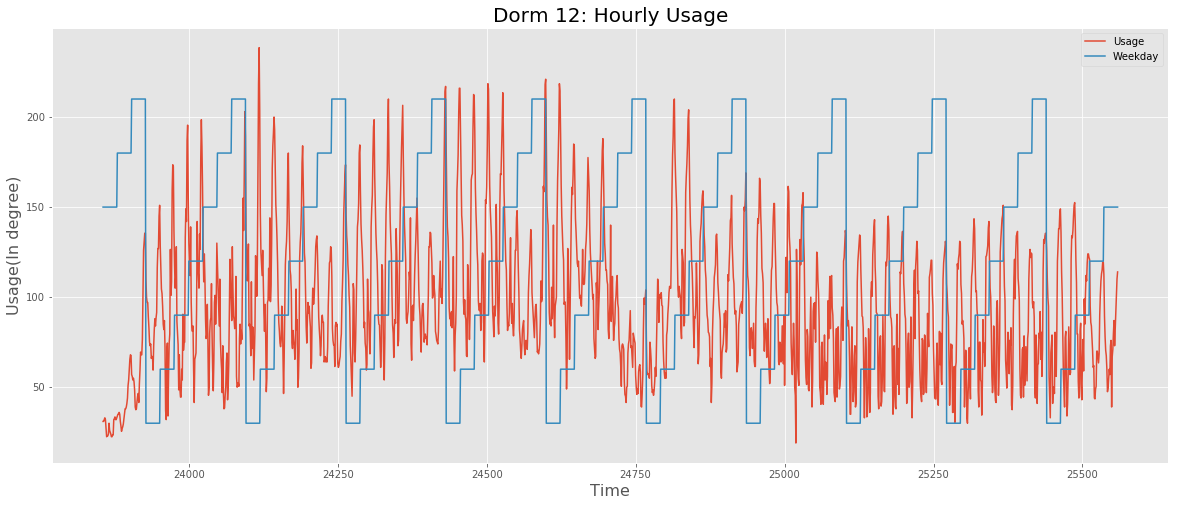

In [124]:
# 71 天每小時的用電資料 (1704個點)
df_dorm_12.Usage.plot(legend = True)
(df_dorm_12.Weekday * 30).plot(legend = True)
# plt.xlabel('index')
plt.title('Dorm 12: Hourly Usage', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Time',fontsize = 16) # 如何改 y index?

### 圖三：平均用電變化 - 依Weekday看
#### 觀察
- 週六大家回家，平均用電最低
- 週日回宿舍，用電比週六週五高

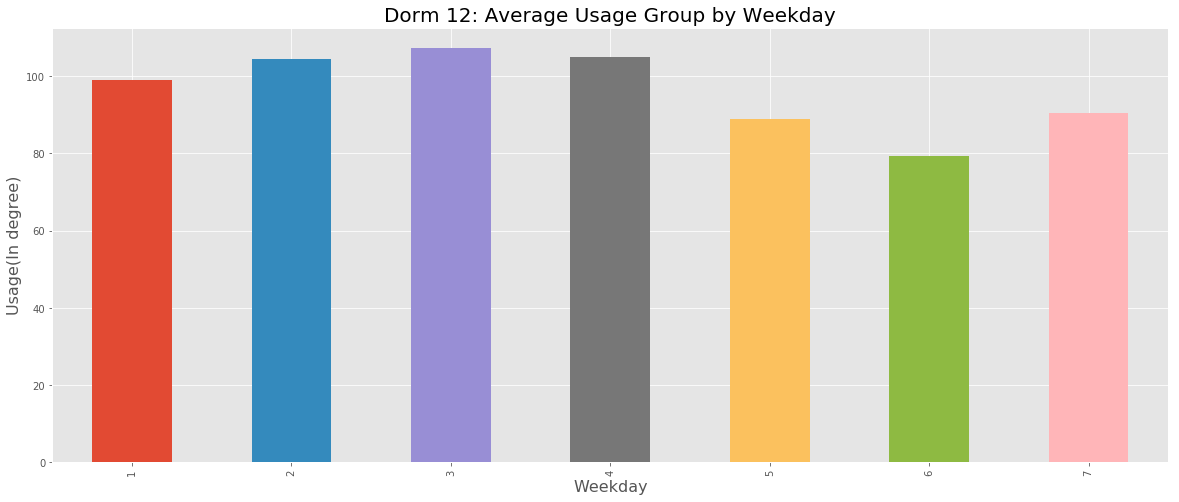

In [125]:
df_dorm_12_byWeekday = df_dorm_12.groupby('Weekday').mean()
df_dorm_12_byWeekday.Usage.plot.bar(legend = False)

plt.title('Dorm 12: Average Usage Group by Weekday', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Weekday',fontsize = 16)

In [88]:
df_dorm_12.Weekday.value_counts()

5    264
7    240
6    240
4    240
3    240
2    240
1    240
Name: Weekday, dtype: int64

In [130]:
df_dorm_12.groupby('Time').groups

{'00:00': Int64Index([23856, 23880, 23904, 23928, 23952, 23976, 24000, 24024, 24048,
             24072, 24096, 24120, 24144, 24168, 24192, 24216, 24240, 24264,
             24288, 24312, 24336, 24360, 24384, 24408, 24432, 24456, 24480,
             24504, 24528, 24552, 24576, 24600, 24624, 24648, 24672, 24696,
             24720, 24744, 24768, 24792, 24816, 24840, 24864, 24888, 24912,
             24936, 24960, 24984, 25008, 25032, 25056, 25080, 25104, 25128,
             25152, 25176, 25200, 25224, 25248, 25272, 25296, 25320, 25344,
             25368, 25392, 25416, 25440, 25464, 25488, 25512, 25536],
            dtype='int64'),
 '01:00': Int64Index([23857, 23881, 23905, 23929, 23953, 23977, 24001, 24025, 24049,
             24073, 24097, 24121, 24145, 24169, 24193, 24217, 24241, 24265,
             24289, 24313, 24337, 24361, 24385, 24409, 24433, 24457, 24481,
             24505, 24529, 24553, 24577, 24601, 24625, 24649, 24673, 24697,
             24721, 24745, 24769, 24793, 24817, 

### 圖四：平均用電變化 - 依小時看

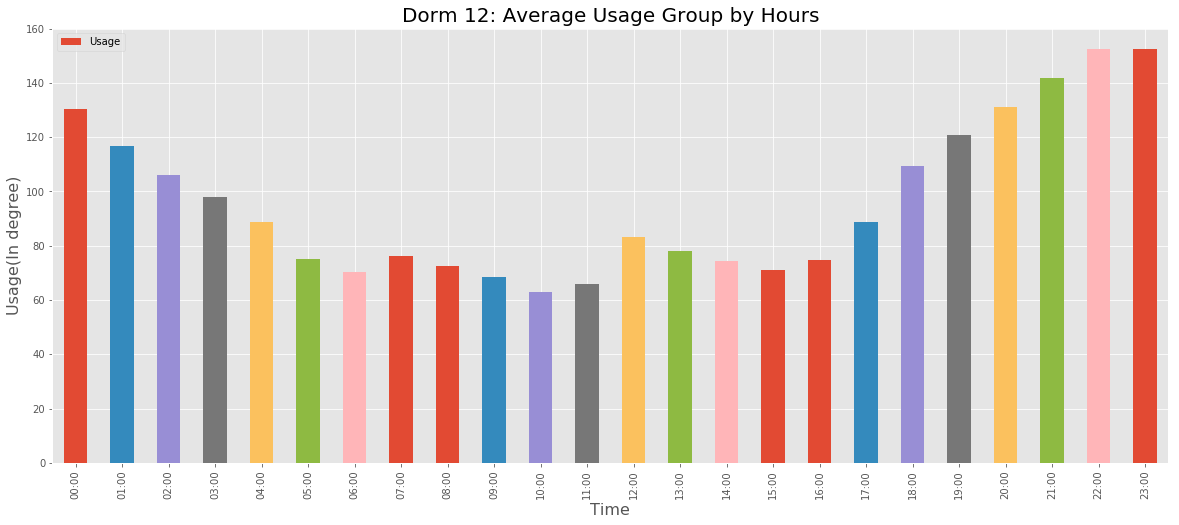

In [98]:
df_dorm_12.groupby('Time').Usage.mean().plot.bar(legend = True)
plt.title('Dorm 12: Average Usage Group by Hours', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Time',fontsize = 16)

### 觀察
- 這張是我覺得最有趣的，想法：可以拿去跟男生十舍比，看十二舍的人是不是比較早睡（省電）
- 最高用電落在晚上十一點到十二點。十二點會關燈。
- 關燈之後的下跌應該就是人為用電的減少（去睡覺了），人為用電除了桌電、吹風機以外，不知道洗澡熱水器有沒有被算在內？
- 早上七點起床有個Peak，可能是洗澡或開燈
- 中午十二點也有Peak，可能是回宿舍吃中飯
- 晚上六點開燈，所以用電升幅大

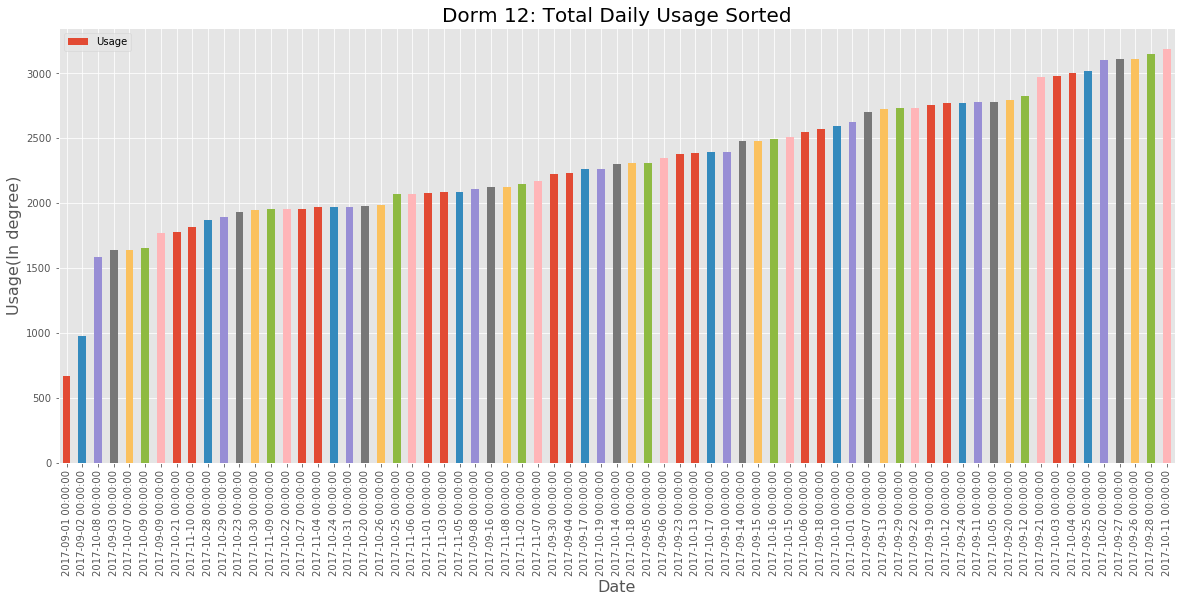

In [91]:
df_dorm_12_dailysum_sorted = df_dorm_12.groupby('Date').sum().sort_values('Usage')
df_dorm_12_dailysum_sorted.Weekday = df_dorm_12_dailysum_sorted.Weekday/24
df_dorm_12_dailysum_sorted.Usage.plot.bar(legend = True)
plt.title('Dorm 12: Total Daily Usage Sorted', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Date',fontsize = 16)

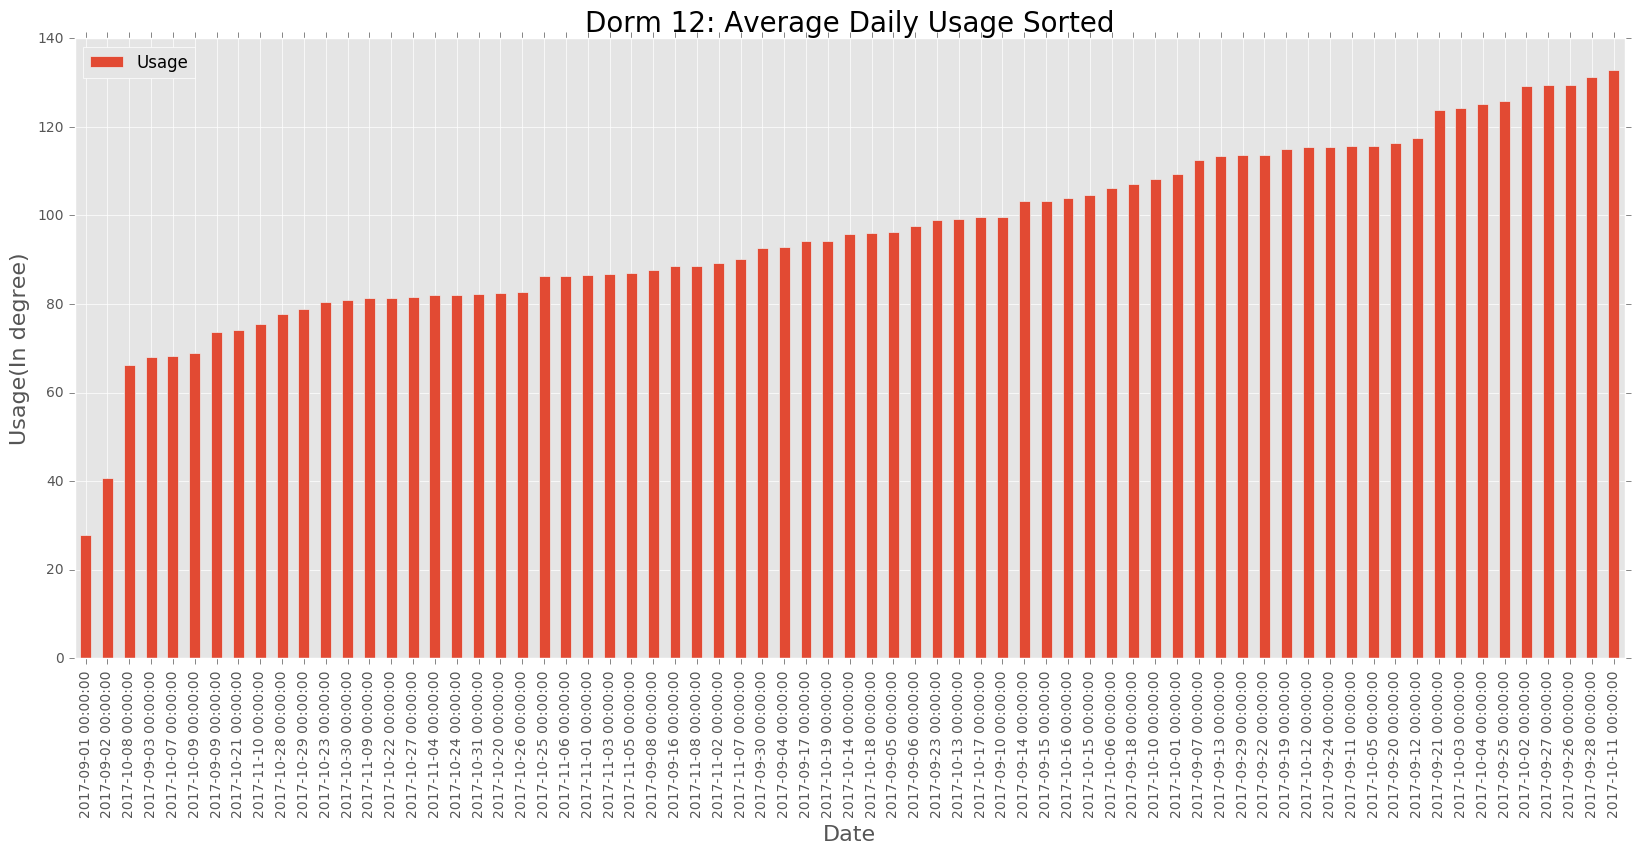

In [58]:
df_dorm_12_dailymean_sorted = df_dorm_12.groupby('Date').mean().sort_values('Usage')
df_dorm_12_dailymean_sorted.Usage.plot.bar(legend = True)
plt.title('Dorm 12: Average Daily Usage Sorted', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Date',fontsize = 16)

In [59]:
# 最高用電的幾天是...
# TBD: 為什麼這幾天會比較高呢？
print('Top 10 daily TOTAL use of dorm 12. From 9.01 - 11.10')
print(df_dorm_12_dailysum_sorted[-10:])
print('Top 10 daily AVERAGE use of dorm 12. From 9.01 - 11.10')
print(df_dorm_12_dailymean_sorted[-10:])

Top 10 daily TOTAL use of dorm 12. From 9.01 - 11.10
             Usage  Weekday  Week    Cost
Date                                     
2017-09-12  2821.5      2.0   888  8464.5
2017-09-21  2973.5      4.0   912  8920.5
2017-10-03  2981.0      2.0   960  8943.0
2017-10-04  3003.0      3.0   960  9009.0
2017-09-25  3019.0      1.0   936  9057.0
2017-10-02  3100.0      1.0   960  9300.0
2017-09-27  3105.0      3.0   936  9315.0
2017-09-26  3108.0      2.0   936  9324.0
2017-09-28  3150.0      4.0   936  9450.0
2017-10-11  3189.5      3.0   984  9568.5
Top 10 daily AVERAGE use of dorm 12. From 9.01 - 11.10
                 Usage  Weekday  Week      Cost
Date                                           
2017-09-12  117.562500        2    37  352.6875
2017-09-21  123.895833        4    38  371.6875
2017-10-03  124.208333        2    40  372.6250
2017-10-04  125.125000        3    40  375.3750
2017-09-25  125.791667        1    39  377.3750
2017-10-02  129.166667        1    40  387.5000
2017

觀察：其實最高用電的前十個日子，用平均或總合來看是一樣的。

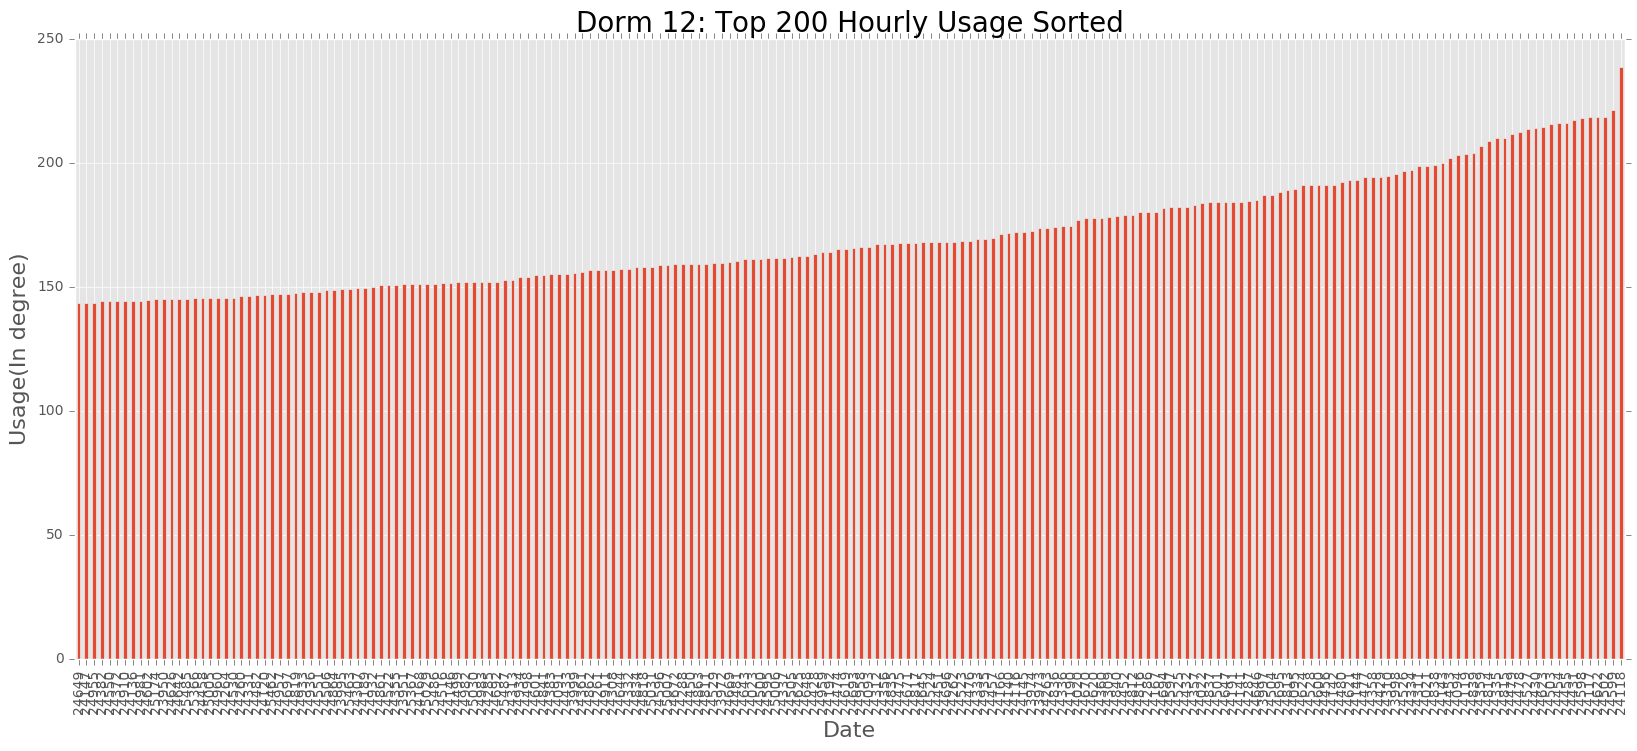

In [60]:
df_dorm_12_sorted_top200 = df_dorm_12.sort_values('Usage')[-200:]
df_dorm_12_sorted_top200.Usage.plot.bar()
plt.title('Dorm 12: Top 200 Hourly Usage Sorted', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Date',fontsize = 16)

In [61]:
# 哪小時最耗電？
df_dorm_12_sorted_top200.Time.value_counts()

22:00    39
23:00    37
21:00    31
00:00    24
20:00    20
01:00    15
19:00    15
02:00     8
18:00     6
03:00     2
12:00     2
16:00     1
Name: Time, dtype: int64

In [62]:
# 星期幾最耗電？
df_dorm_12_sorted_top200.Weekday.value_counts()

3    45
2    45
4    40
1    33
7    21
5    14
6     2
Name: Weekday, dtype: int64

DateTime       Area Building      Loop  Type  Usage       Date  \
24118  2017/09/11 22:00  southArea  dorm_12  mainLoop  dorm  238.5 2017-09-11   

       Weekday   Time  Week   Cost  
24118        1  22:00    37  715.5

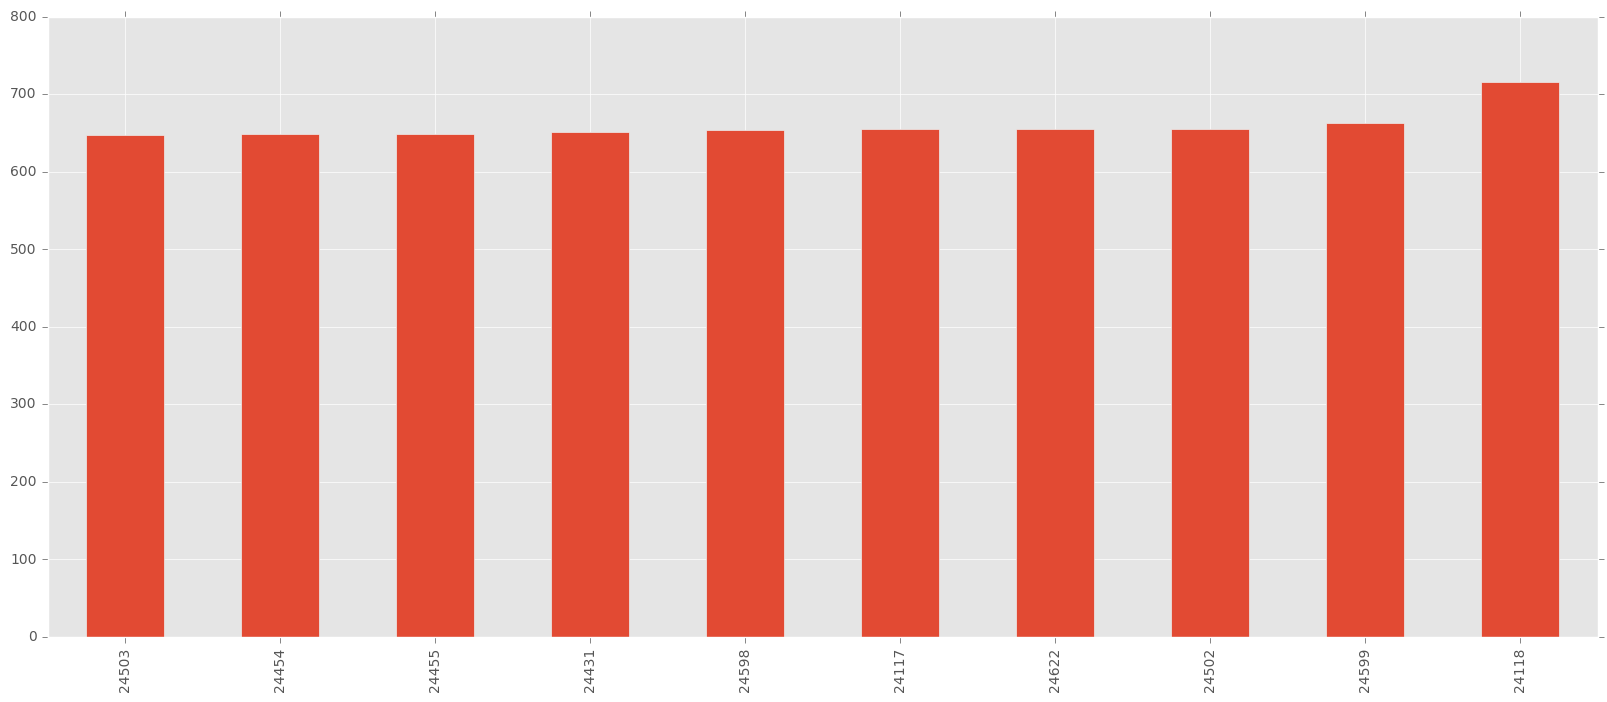

In [63]:


df_dorm_12_sorted_top200[-10:].Cost.plot.bar()
#發現有一天真的特耗電

df_dorm_12_sorted_top200[-1:]
# 2017/09/11 22:00 用電是 238.5, (12舍平均用電是96)

2017/9/11 為什麼用那麼多電呢？
我去查了日曆，原來是開學日啊！

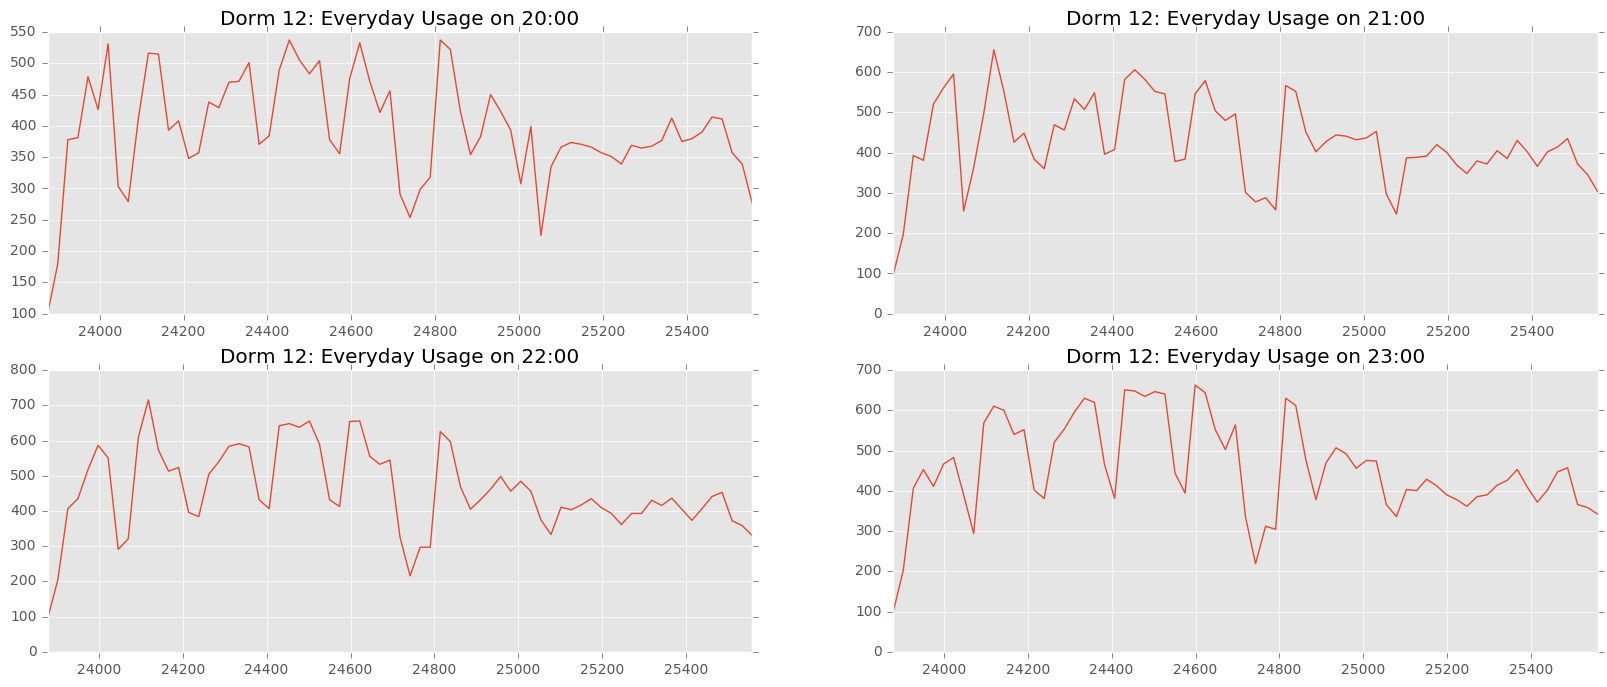

In [64]:
# 觀看某一個小時的用電量，在每天的變化

# df_dorm_12[df_dorm_12.Time == '23:00'].info()
fig, axes = plt.subplots(nrows=2, ncols=2)
df_dorm_12[df_dorm_12.Time == '20:00'].Cost.plot(ax=axes[0,0],title = 'Dorm 12: Everyday Usage on 20:00')
df_dorm_12[df_dorm_12.Time == '21:00'].Cost.plot(ax=axes[0,1],title = 'Dorm 12: Everyday Usage on 21:00')
df_dorm_12[df_dorm_12.Time == '22:00'].Cost.plot(ax=axes[1,0],title = 'Dorm 12: Everyday Usage on 22:00')
df_dorm_12[df_dorm_12.Time == '23:00'].Cost.plot(ax=axes[1,1],title = 'Dorm 12: Everyday Usage on 23:00')


In [103]:
# 未完成
# 觀看24小時分別的用電量，在每天的變化


df_dorm_12.Time.unique()
morning = ['01:00', '02:00', '03:00', '04:00', '05:00', '06:00','07:00', '08:00']
afternoon = ['09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00']
night = [ '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00','00:00']
# df_dorm_12.Time.item in ['18:00','19:00']
# df_dorm_12_byTime_m = df_dorm_12[df_dorm_12.Time.valus in morning].groupby('Time')
# df_dorm_12_byTime_a = df_dorm_12[df_dorm_12.Time in afternoon].groupby('Time')
# df_dorm_12_byTime_n = df_dorm_12[df_dorm_12.Time in night].groupby('Time')

df_dorm_12_byTime = df_dorm_12.groupby('Time')
df_dorm_12_byTime.Usage.unstack().plot.bar(legend = False)
plt.title('Every day Uasge in __:00', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Day',fontsize = 16)


# bins = [0, 5, 15, 30]
# names = ['Cheap', 'Normal', 'Expensive']
# df_dorm_12_byTime_m = pd.cut(df_dorm_12.Time,bins, labels=morning)

AttributeError: Cannot access callable attribute 'unstack' of 'SeriesGroupBy' objects, try using the 'apply' method

Week
35    Axes(0.125,0.125;0.775x0.755)
36    Axes(0.125,0.125;0.775x0.755)
37    Axes(0.125,0.125;0.775x0.755)
38    Axes(0.125,0.125;0.775x0.755)
39    Axes(0.125,0.125;0.775x0.755)
40    Axes(0.125,0.125;0.775x0.755)
41    Axes(0.125,0.125;0.775x0.755)
42    Axes(0.125,0.125;0.775x0.755)
43    Axes(0.125,0.125;0.775x0.755)
44    Axes(0.125,0.125;0.775x0.755)
45    Axes(0.125,0.125;0.775x0.755)
Name: Usage, dtype: object

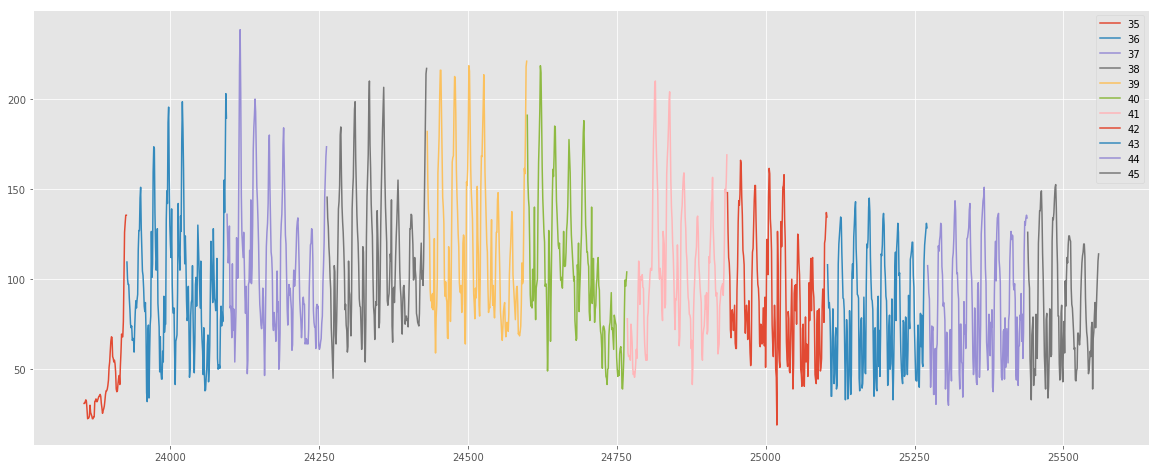

In [92]:
df_dorm_12.groupby(['Week']).Usage.plot(legend = True)
#.Usage.plot(legend = True)

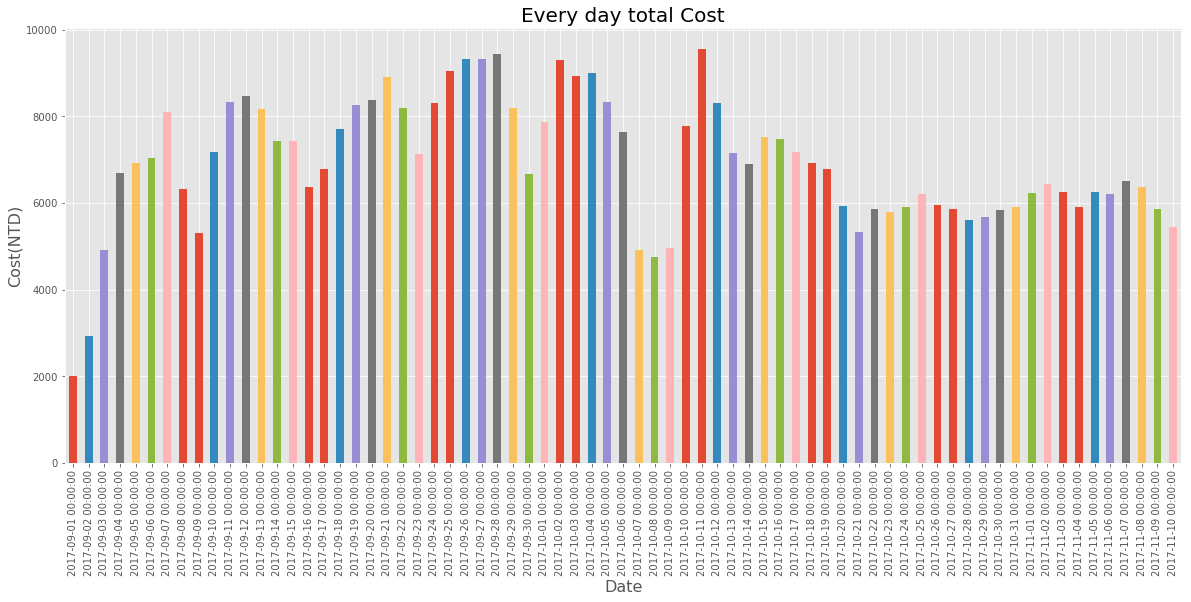

In [93]:
# df_dorm_12.groupby('Date').sum().Usage.plot.bar()
df_dorm_12.groupby('Date').sum().Cost.plot.bar()
plt.title('Every day total Cost', fontsize = 20)
pylab.ylabel('Cost(NTD)',fontsize = 16)
pylab.xlabel('Date',fontsize = 16)

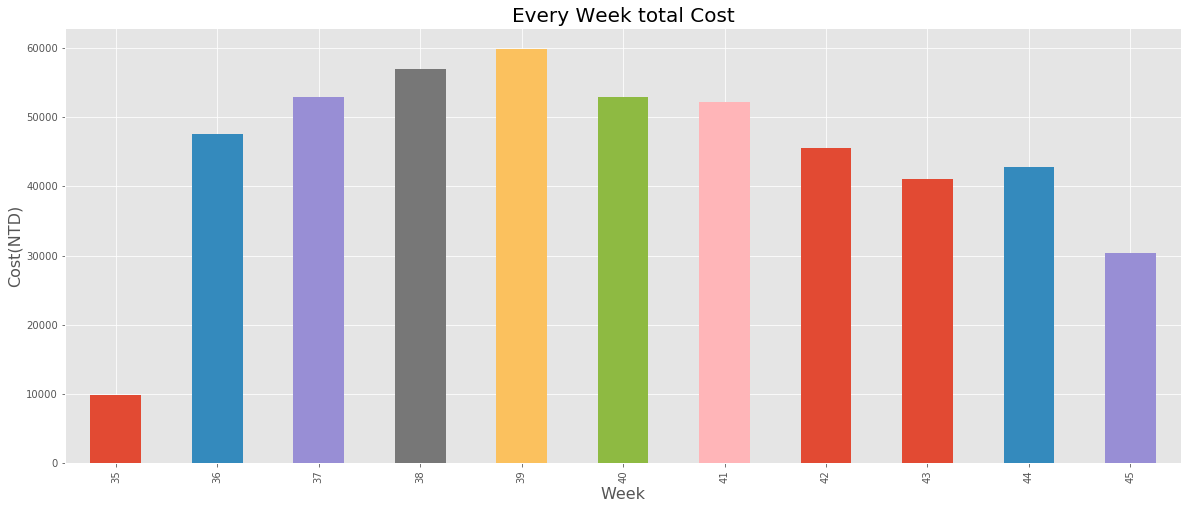

In [94]:
# df_dorm_12.groupby('Date').sum().Usage.plot.bar()
df_dorm_12.groupby('Week').sum().Cost.plot.bar()
plt.title('Every Week total Cost', fontsize = 20)
pylab.ylabel('Cost(NTD)',fontsize = 16)
pylab.xlabel('Week',fontsize = 16)

In [76]:
# df_dorm_12.groupby(['Time','Week']).Usage.plot(legend = True)
#.Usage.plot(legend = True)

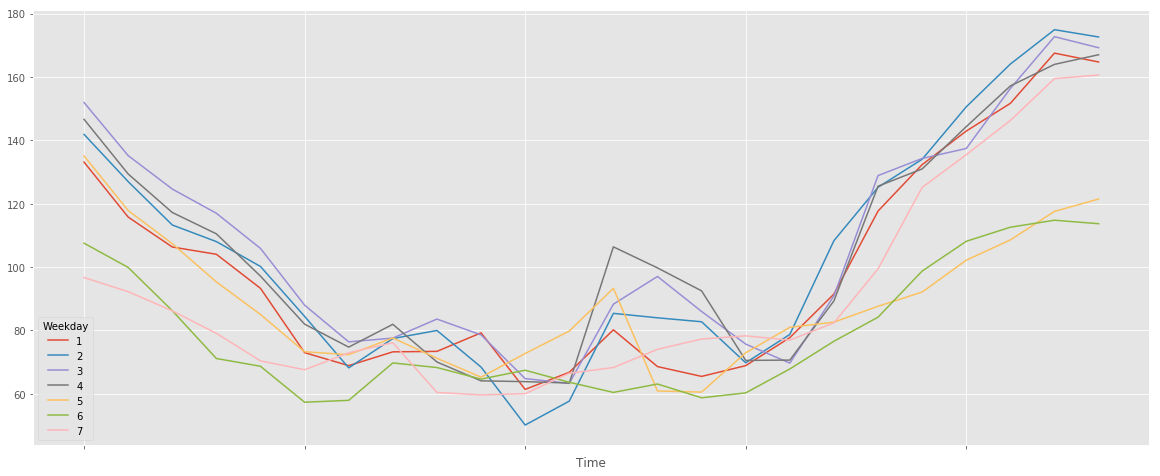

In [95]:
df_dorm_12.groupby(['Time','Weekday']).Usage.mean().unstack().plot(legend = True)
#.Usage.plot(legend = True)

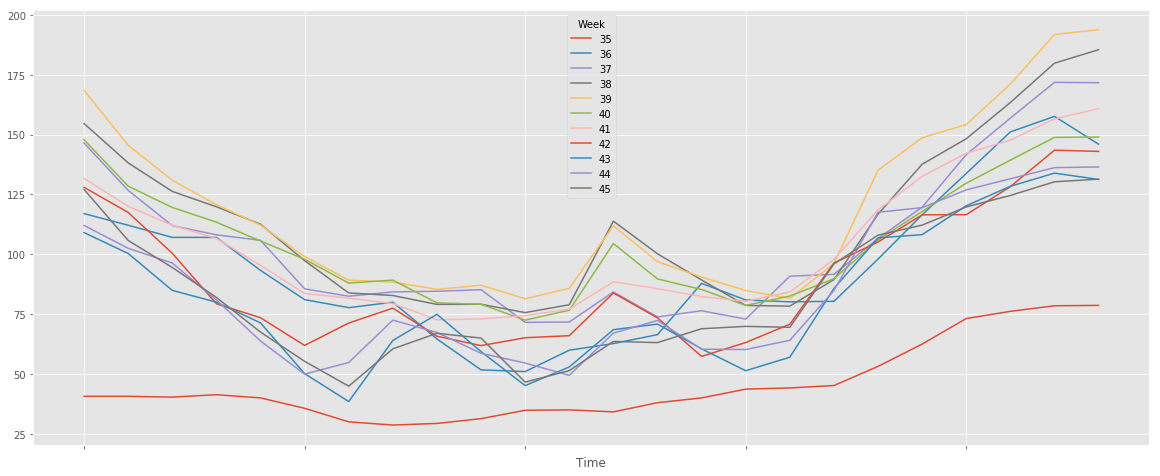

In [96]:
df_dorm_12.groupby(['Time','Week']).Usage.mean().unstack().plot(legend = True)
#.Usage.plot(legend = True)

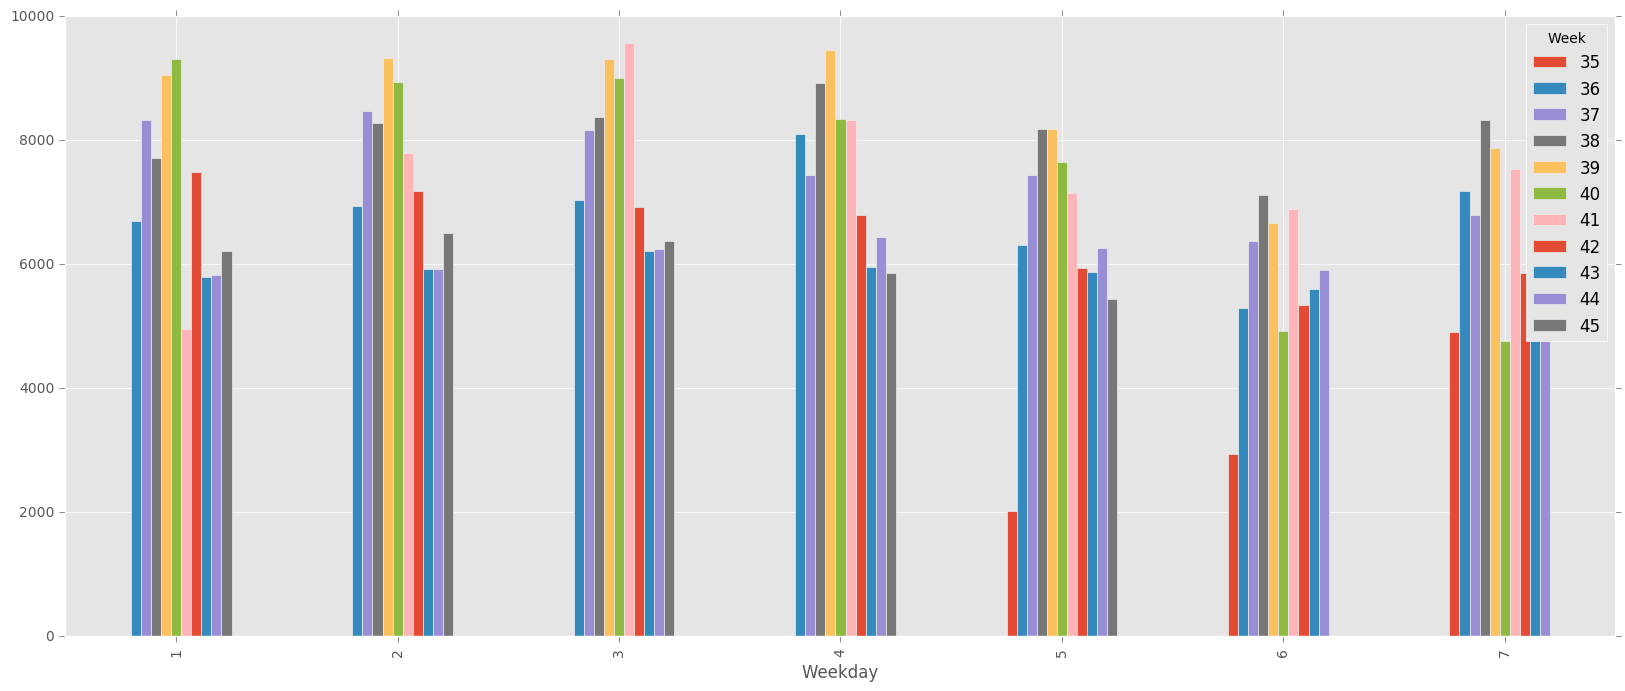

In [98]:
df_dorm_12.groupby(['Weekday','Week']).Cost.sum().unstack().plot.bar(legend = True)
#.Usage.plot(legend = True)

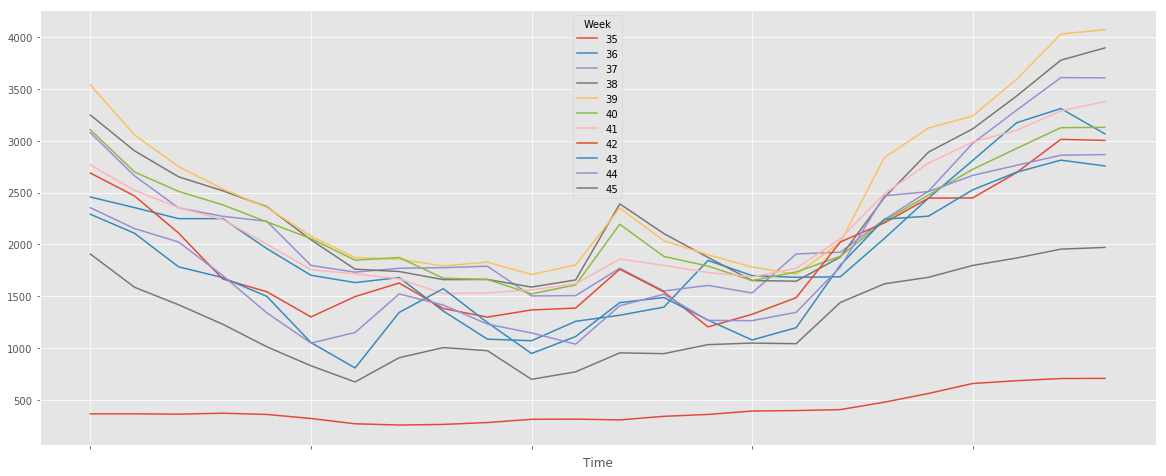

In [97]:
df_dorm_12.groupby(['Time','Week']).Cost.sum().unstack().plot(legend = True)
#.Usage.plot(legend = True)